# COVID-19 Data Aggregation
### This script aggregates JHU data to the CBSA-level and applies R0 calculations to case data. 

In [82]:
import matplotlib.pyplot as plt
import pandas as pd
import math
import copy

## CBSA Crosswalk Import

In [93]:
crosswalk_df = pd.read_csv('./data/cbsa-county-region-crosswalk.csv')
crosswalk_df['FIPS State Code']  = crosswalk_df['FIPS State Code'].astype(str).str.zfill(2)
crosswalk_df['FIPS County Code'] = crosswalk_df['FIPS County Code'].astype(str).str.zfill(3)
crosswalk_df['FIPS'] = (crosswalk_df['FIPS State Code'] + crosswalk_df['FIPS County Code']).astype(int)
crosswalk_df = crosswalk_df[['CBSA Code','FIPS']]
crosswalk_df.columns = ['GTCBSA', 'FIPS']
# crosswalk_df.head()

## JHU Covid Data Import

In [94]:
case_df = pd.read_csv('./data/time_series_covid19_confirmed_US.csv')
dates = case_df.columns.tolist()[11:]
case_df = case_df[['FIPS']+dates]
case_df = case_df[~case_df['FIPS'].isna()]
case_df['FIPS'] = case_df['FIPS'].astype(int)
# case_df.head()

## CBSA Aggregation

In [95]:
crosswalked_cases = crosswalk_df.merge(case_df, how='left', on='FIPS')
crosswalked_cases = crosswalked_cases[[i for i in crosswalked_cases.columns.tolist() if i!='FIPS']]
crosswalked_cases = crosswalked_cases.groupby('GTCBSA').sum()
#crosswalked_cases = crosswalked_cases.reset_index()
crosswalked_cases

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
GTCBSA                                                                  
10100       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
10140       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
10180       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
10220       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
10260       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
...         ...      ...      ...      ...      ...      ...      ...   
49660       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
49700       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
49740       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
49780       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
49820       0.0      0.0      0.0      0.0      0.0      0.0      0.0   

        1/29/20  1/30/20  1/31/20  ...  6/17/21  6/18/21  6/19/21  6/20/21  \
GTCBSA                             ...                                       
10100       0.0      0.0      0.0  ...   6149.0   6149.0   6149.0   6149.0   
10140       0.0      0.0      0.0  ...   4537.0   4543.0   4557.0   4557.0   
10180       0.0      0.0      0.0  ...  19701.0  19716.0  19707.0  19707.0   
10220       0.0      0.0      0.0  ...   5172.0   5172.0   5172.0   5172.0   
10260       0.0      0.0      0.0  ...    468.0    468.0    468.0    468.0   
...         ...      ...      ...  ...      ...      ...      ...      ...   
49660       0.0      0.0      0.0  ...  48595.0  48616.0  48629.0  48639.0   
49700       0.0      0.0      0.0  ...  16114.0  16114.0  16141.0  16141.0   
49740       0.0      0.0      0.0  ...  37283.0  37283.0  37284.0  37284.0   
49780       0.0      0.0      0.0  ...   8906.0   8906.0   8906.0   8906.0   
49820       0.0      0.0      0.0  ...   1789.0   1792.0   1792.0   1792.0   

        6/21/21  6/22/21  6/23/21  6/24/21  6/25/21  6/26/21  
GTCBSA                                                        
10100    6151.0   6155.0   6155.0   6155.0   6155.0   6155.0  
10140    4558.0   4563.0   4570.0   4574.0   4574.0   4579.0  
10180   19707.0  19710.0  19723.0  19725.0  19726.0  19735.0  
10220    5172.0   5172.0   5174.0   5174.0   5174.0   5174.0  
10260     468.0    468.0    468.0    468.0    468.0    468.0  
...         ...      ...      ...      ...      ...      ...  
49660   48646.0  48655.0  48661.0  48671.0  48686.0  48704.0  
49700   16152.0  16178.0  16191.0  16197.0  16197.0  16210.0  
49740   37287.0  37290.0  37294.0  37297.0  37305.0  37308.0  
49780    8907.0   8908.0   8909.0   8912.0   8913.0   8914.0  
49820    1792.0   1792.0   1795.0   1798.0   1799.0   1799.0  

[929 rows x 522 columns]

## $R_0$ Calculation

The Alpha Variant of Covid 19 was predominant in the USA in 2020.  
This variant has an incubation period of 5.0 days.  
Sources:  
https://jamanetwork.com/journals/jamanetworkopen/fullarticle/2795489
https://www.yalemedicine.org/news/covid-19-variants-of-concern-omicron#:~:text=a%20coronavirus%20variant.-,Beta,not%20common%20in%20the%20U.S.

The infectious period is an additional 5.0 days.  
Sources:  
https://www.thelancet.com/journals/lanres/article/PIIS2213-2600(22)00226-0/fulltext#:~:text=The%20onset%20and%20end%20of,35%20shed%20infectious%20virus%20presymptomatically.  

In conjunction, these provide T_G as 10 days, with each component being 5.0.  

In [164]:
T_E = 5
T_I = 5
T_G = T_E+T_I
rho = T_E/T_G
gamma1 = 1/T_E
gamma2 = 1/T_I

def calc_r0(ln_yt, t):
    if t>0:
        lam = ln_yt/(t)
        r0 = (1+(lam/gamma1))*(1+(lam/gamma2))
        return r0
    else:
        return 0


def split_0s(data):
    zeros = []
    nonzeros = []

    for i in data:
        if i == 0 and len(nonzeros) == 0:
            zeros.append(0)
        else:
            nonzeros.append(i)
    return zeros, nonzeros


def process_log_cases(data):
    if sum(data) == 0:
        return(data, [])
    else:
        return split_0s(data)


def process_log_cases(data): # no split
    return([], data)
    # if sum(data) == 0:
    #     return(data, [])
    # else:
    #     return split_0s(data)
        


In [165]:
data_df = copy.deepcopy(crosswalked_cases)

data_df = data_df.T
for cbsa in data_df.columns:
    data = data_df[cbsa].tolist()

    zeros, nonzeros = process_log_cases(data)
    if len(nonzeros) > 0:
        log = [math.log(i) if i > 0 else 0 for i in nonzeros]
        r_0s = [calc_r0(log[i], i+1) for i in range(len(log))]
        updated = zeros + r_0s
    else:
        updated = zeros


    #print(cbsa, nonzeros[0])
    # if sum(data) > 0:
    #     zeros = []
    #     while data[0] == 0:
    #         zeros.append(data.pop(0))
    #     if len(data) > 0:
    #         data = [math.log(i) if i > 0 else 0 for i in data]
    #         r_0s = [calc_r0(data[i], i+1) for i in range(len(data))]
    #     data = zeros + data
    #     #print(cbsa, len(zeros),len(data))
    #     #if len(data) > 0:
    #     #    print(data)
    data_df[cbsa] = updated

data_df = data_df.T
    
data_df

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
GTCBSA                                                                  
10100       1.0      1.0      1.0      1.0      1.0      1.0      1.0   
10140       1.0      1.0      1.0      1.0      1.0      1.0      1.0   
10180       1.0      1.0      1.0      1.0      1.0      1.0      1.0   
10220       1.0      1.0      1.0      1.0      1.0      1.0      1.0   
10260       1.0      1.0      1.0      1.0      1.0      1.0      1.0   
...         ...      ...      ...      ...      ...      ...      ...   
49660       1.0      1.0      1.0      1.0      1.0      1.0      1.0   
49700       1.0      1.0      1.0      1.0      1.0      1.0      1.0   
49740       1.0      1.0      1.0      1.0      1.0      1.0      1.0   
49780       1.0      1.0      1.0      1.0      1.0      1.0      1.0   
49820       1.0      1.0      1.0      1.0      1.0      1.0      1.0   

        1/29/20  1/30/20  1/31/20  ...   6/17/21   6/18/21   6/19/21  \
GTCBSA                             ...                                 
10100       1.0      1.0      1.0  ...  1.177289  1.176930  1.176573   
10140       1.0      1.0      1.0  ...  1.170868  1.170550  1.170271   
10180       1.0      1.0      1.0  ...  1.202046  1.201651  1.201232   
10220       1.0      1.0      1.0  ...  1.173633  1.173281  1.172931   
10260       1.0      1.0      1.0  ...  1.123444  1.123197  1.122951   
...         ...      ...      ...  ...       ...       ...       ...   
49660       1.0      1.0      1.0  ...  1.221419  1.220976  1.220531   
49700       1.0      1.0      1.0  ...  1.197754  1.197352  1.196987   
49740       1.0      1.0      1.0  ...  1.215717  1.215277  1.214839   
49780       1.0      1.0      1.0  ...  1.185137  1.184762  1.184388   
49820       1.0      1.0      1.0  ...  1.151321  1.151051  1.150748   

         6/20/21   6/21/21   6/22/21   6/23/21   6/24/21   6/25/21   6/26/21  
GTCBSA                                                                        
10100   1.176217  1.175869  1.175529  1.175178  1.174827  1.174478  1.174130  
10140   1.169928  1.169591  1.169273  1.168967  1.168647  1.168311  1.167999  
10180   1.200824  1.200418  1.200016  1.199627  1.199228  1.198829  1.198441  
10220   1.172583  1.172236  1.171890  1.171554  1.171211  1.170869  1.170529  
10260   1.122706  1.122462  1.122219  1.121976  1.121735  1.121495  1.121255  
...          ...       ...       ...       ...       ...       ...       ...  
49660   1.220087  1.219643  1.219202  1.218761  1.218324  1.217891  1.217461  
49700   1.196588  1.196205  1.195844  1.195466  1.195082  1.194691  1.194318  
49740   1.214402  1.213969  1.213538  1.213109  1.212681  1.212258  1.211833  
49780   1.184016  1.183647  1.183280  1.182914  1.182555  1.182192  1.181831  
49820   1.150445  1.150144  1.149844  1.149580  1.149317  1.149031  1.148736  

[929 rows x 522 columns]

Text(0.5, 0, 'Days since 1/22/2020')

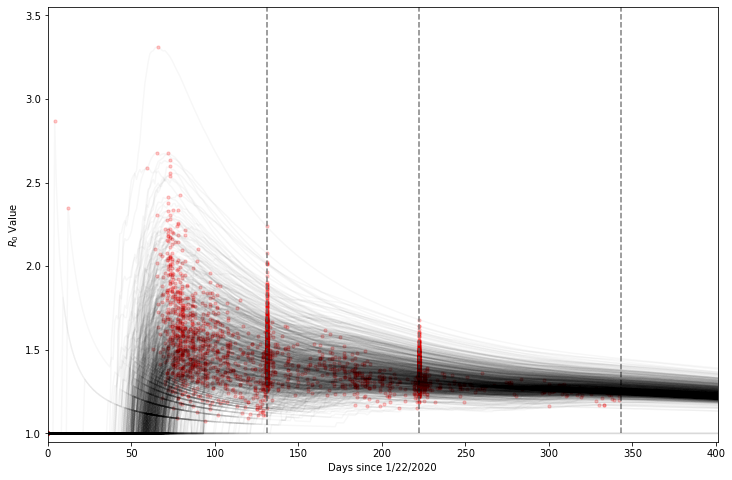

In [189]:
data_idx_df = data_df.reset_index()

plt.figure(figsize=(12,8))
for i in range(len(data_idx_df)):
    data  = data_idx_df.loc[i].tolist()[1:]
    x     = [i for i in range(len(data))]
    x     = [x[i]    for i in range(len(x))    if data[i]>0]
    r_0   = [data[i] for i in range(len(data)) if data[i]>0]
    plt.plot(x,r_0, c='black', alpha=0.03)
    max_y = [max(r_0[:131]), max(r_0[131:222]), max(r_0[222:343])]
    max_x = [r_0.index(i) for i in max_y]
    plt.scatter(max_x, max_y, c='red', s=10, alpha=0.2)

plt.vlines(131,1,4,colors='grey',linestyles='--') #june first
plt.vlines(222,1,4,colors='grey',linestyles='--') #sept first
plt.vlines(343,1,4,colors='grey',linestyles='--') #year end

plt.ylim(.95,3.55)
plt.xlim(0,401)
#plt.yscale('log')

plt.ylabel('$R_0$ Value')
plt.xlabel('Days since 1/22/2020')